# Prédiction du temps de transcodage des vidéos

1. [Introduction au transcodage](#Introduction-au-transcodage)
2. [Initialisation](#Initialisation)
3. [Exploration des données](#Exploration-des-données)
4. [Modélisation](#Modélisation)

On utilise deux datasets provenant du *Machine Learning Repository* de l'UCI, regroupés sour la référence [Online Video Characteristics and Transcoding Time Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Video+Characteristics+and+Transcoding+Time+Dataset). Ces datasets sont les suivants :
* Le premier dataset : `youtube_videos.tsv`, contenant 10 colonnes de caractéristiques diverses de vidéos YouTube ;
* Le second dataset : `transcoding_mesurment.tsv`, contenant 20 colonnes de données relatives au transcodage de vidéos issues du premier dataset, mené sur une machine Intel i7-3720QM CPU grâce au logiciel FFmpeg 4.

Comme nous allons le voir, l'intérêt de tels datasets est de prédire la durée de transcodage de ces vidéos afin d'améliorer le confort de visionnage des utilisateurs. Nous allons pour cela opérer diverses régressions sur les jeux de données afin de déterminer du mieux possible la durée de transcodage et la mémoire allouée à ce transcodage.

----

## 1. Introduction au transcodage

1. Intérêt du transcodage et de l'étude
2. Fonctionnement du transcodage

Cette partie introductive est également disponible dans le fichier README.

### 1.1. Intérêt du transcodage et de l'étude

En vidéo, le transcodage est le fait de changer le format de codage d'un média pour le comprimer ou l'encapsuler dans un fichier, ou pour transporter un signal analogique ou numérique. Bien souvent, la transformation comporte des pertes d'information.

Pour illustrer la nécessité du transcodage des vidéos au quotidien, prenons l'exemple des DVD du commerce du début des années 2010. Au format PAL (25 images par seconde), un film de DVD a une résolution de 720 par 576 pixels. Pour un codage RGB sur 3 octets, cela équivaut à 720 x 557 = 414 720 pixels par image, soit 414 720 x 3 octets pour coder la couleur et la luminance de chaque point. Une image de film fait donc 1 244 160 octets, soit 1 215 ko. À raison de 25 images par seconde, on atteint 30 375 ko, soit 29 Mo par seconde, 1 780 Mo par minute et 104 Go par heure !

Les DVD commerciaux ne pouvant contenir que 4,7 ou 9 Go d'informations, il est nécessaire de compresser l'information et de donc de réaliser un transcodage, d'une source lourde à un fichier de sortie réduit.

A une époque où les résolutions d'images sur des sites web d'hébergement de vidéos augmentent considérablement (on trouve des vidéos de 3 840 x 2 160 pixels sur YouTube aujourd'hui) et où la demande et l'exigeance des consommateurs augmente sur ces plateformes de streaming, il parait pertinent de savoir exploiter les données liées à l'encodage de vidéos pour estimer la durée totale de transcodage de ces dernières ou l'espace mémoire total utile au traitement de ces vidéos.

### 1.2. Fonctionnement du transcodage

Pour "lire" et "écrire" un fichier de vidéo, on utilise un dispositif appelé codec, de l'anglais *coder-decoder*. Différent du *container*, que l'on appelle plus simplement le format de la vidéo (mp4, mov, avi...) et qui regroupe l'ensemble des données image, audio, textuelles et méta, le codec est une implémentation logicielle d'une norme de compression, pour les vidéos dans notre cas. Les codecs les plus répandus aujourd'hui pour la vidéo sont :
* le H.264, datant de 2003, que l'on retrouve dans les fichiers mp4, est le plus utilisé et supporté des codecs ;
* le H.265, sorti en 2013, successeur du H.264. Il a une réduction de bitrate améliorée, mais nécessite plus de ressources et reste peu utilisé ;
* le VP9, développé en 2012 par Google pour YouTube, moins supporté et gourmand en ressources, mais intéressant pour des vidéos en straming et à haute résolution.

Pour compresser un fichier, on peut utiliser des algorithmes de compression sans perte, dits *lossless*, qui nous donnent la garantie qu'aucune information ne disparait lors d'une compression. La compression au format zip en est un. Pour réduire encore plus la taille d'un fichier, il faut accepter de perdre définitivement quelques informations jugées moins utiles. C'est le cas pour les vidéos. Ainsi, la plupart des opérations de transcodage réduisent la quantité d'informations que l'on aura à l'écran lorsque la vidéo sera lue. De plus, pour traiter la décompression et "décoder" les informations relatives à la compression, la machine a besoin de mémoire vive. Plus les opérations de compression seront complexes, plus l'ordinateur devra calculer. Il faut donc trouver le juste équilibre entre la taille du fichier, la qualité de la vidéo et la mémoire vive allouée à la lecture de la vidéo.

On détaille maintenant quelques techniques utilisées par les codecs pour compresser une vidéo.

#### 1.2.1. Sous échantillonnage de la chrominance

La première des techniques est évidemment la réduction, certes relative, de la résolution d'une image. Si les dimensions en hauteur et en largeur de la vidéo ne changent pas, le transcodeur peut procéder à une réduction du nombre de pixels "utiles". Un pixel étant défini à la fois par sa luminance Y, sa chrominance bleue Cb et sa chrominance rouge Cr, on peut échantillonner l'image pour définir localement les propriétés des pixels selon l'échantillon auxquels ils appartiennent. Pour conserver une bonne qualité d'image, on pourra par exemple décider que dans un échantillon, si tous les pixels prennent les mêmes chrominances Cb et Cr, ils conservent chacun leur luminance Y individuelle.

![CC BY-SA 4.0 - Ellande - Wikipédia](https://upload.wikimedia.org/wikipedia/commons/1/13/Sous-%C3%A9chantillonnage_de_la_chrominance.png)

Les structures d'échantillonnage sont définies par leurs chiffres J:a:b :
* J est le nombre d'échantillons de luminance (Y) par ligne (toujours identique sur les deux lignes de J pixels). Habituellement, 4 ;
* a est le nombre d'échantillons de chrominance (Cb, Cr) sur la première ligne de pixels ;
* b est le nombre d'échantillons de chrominance (Cb, Cr) sur la deuxième ligne de pixels.

#### 1.2.2. Compression spatiale

Une seconde technique consiste à identifier dans une image de vidéo les régions où la couleur est similaire à un seuil déterminée au préalable. Plus une image de vidéo contient de pixels adjacents similaires, plus cette dernière pourra être compressée et son information simplifiée.

Selon le seuil choisi, on pourra remarquer sur la vidéo la présence de rectangles dans lesquels la couleur est identique. Plus la compression est forte, plus les détails d'une image disparaissent.

#### 1.2.3. Compression temporelle

La dernière technique de compression de vidéo est la compression temporelle. Il s'agit de la plus importante des techniques dans le cadre de notre étude, car, comme nous allons le voir, de nombreuses données de nos datasets portent sur cette méthode et son fonctionnement. Ici, on ne compresse plus la vidéo image par image mais également sur des périodes temporelles. Des images qui se suivent sur une vidéo comprennent souvent les mêmes objets ou les mêmes paysages. Pour gagner de la place mémoire, on peut considérer que seule l'information de la première image à laquelle apparaît un objet ou un paysage est conservée. Dans le fichier compressé, aucune des images suivantes ne contiendra l'information de l'objet identifié. Elles ne conserveront que la référence expliquant que l'information est à récupérer à l'image précédente. Il est possible de faire de même dans "l'autre sens", en allant chercher une information à l'image suivante. 

Cette technique est d'autant plus intéressante qu'elle est également applicable à des objets en mouvement sur un fond immobile. L'information conservée sur ces images n'est alors que le mouvement de translation de la voiture, les autres informations relatives au fond et à la forme de la voiture étant contenues dans les images précédentes.

Là aussi, la question de similarité des objets ou des paysages entre plusieurs *frames* est sujette à un "seuil de ressemblance". Plus le seuil sera élevé, plus on perdra de petites informations qui pourraient différencier les parties similaires des différentes images et donc moins bonne sera la qualité de la vidéo. De même, aller chercher une information visuelle à une *frame* suivante ou précédente nécessite plus de ressources.

![[Public domain]](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/I_P_and_B_frames.svg/1920px-I_P_and_B_frames.svg.png)

On identifie alors plusieurs types d'images (*frames*) :
* les *i frames* (*intra-coded picture*), des images complètes contenant toutes l'information dont elles ont besoin ;
* les *p frames* (*predicted picture*), des images ne conservant que les changements par rapport à la précédente image ;
* les *b frames* (*bidirectionnal predicted picture*), des images ne conservant que les changements par rapport à l'image précédente et à l'image suivante. Le traitement de ces images est plus gourmand en ressources.

Les images p et b sont également appelées *inter frames*. Selon le codec, les références aux images précédentes et suivantes peuvent ne concerner qu'une image adjacente ou une image plus éloignée (dans le cas ou l'objet reste immobile plusieurs images d'affilées). Dans le premier cas, le transcodeur doit donc aller, image après image, jusqu'à l'information, ce qui est potentiellement plus gourmand en ressources.

Le codec MPEG-1 utilise également des *d frames*, mais leur intérêt limité a poussé les développeurs à ne pas les intégrer à des codecs plus récents.

----

## 2. Initialisation

1. Bibliothèques et paramètres
2. Récupération des données
3. Traitement des données
4. Répartitions des données

Une fois les datasets téléchargés (à défaut, se référer au REAMDE.md), on peut initialiser le Notebook.

### 2.1. Bibliothèques et paramètres

In [1]:
# Importation des bibliothèques
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Effacement des messages d'erreur non essentiels (dus à des problèmes de comptabilité avec les bibliothèques importées)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Création des palettes pour la data-vizualisation
palette_codec = { "h264": "C0", "flv1": "C1", "flv": "C1", "mpeg4": "C2", "vp8": "C3", "none": "k"}

color = sns.color_palette()
style.use("bmh")

### 2.2. Données

On récupère d'abord les données de `youtube_videos.tsv` que l'on met sous forme de DataFrame.

In [4]:
df_youtube_videos = pd.read_csv("input/youtube_videos.tsv",sep="\t")

# Premières lignes du dataset
df_youtube_videos.head()

,id,duration,bitrate,bitrate(video),height,width,frame rate,frame rate(est.),codec,category,url
0,uDNj-_5ty48,267,373,274,568,320,29.97,0.00,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
1,uDNj-_5ty48,267,512,396,480,270,29.97,29.97,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
2,uDNj-_5ty48,267,324,263,400,226,29.97,29.97,flv1,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
3,uDNj-_5ty48,267,85,55,176,144,12.00,12.00,mpeg4,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
4,WCgt-AactyY,31,1261,1183,640,480,24.00,0.00,h264,People & Blogs,http://r1---sn-ovgq0oxu-5goe.c.youtube.com/vid...


In [5]:
# Statistiques des valeurs numériques du dataset
df_youtube_videos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,168286.0,271.654184,552.881871,1.0,55.00,145.00,289.00,25845.00
bitrate,168286.0,730.621490,919.154730,0.0,289.00,459.00,826.00,22421.00
bitrate(video),168286.0,624.363025,860.955654,0.0,231.00,349.00,640.00,22229.00
height,168286.0,561.018706,359.071569,100.0,320.00,480.00,640.00,2592.00
width,168286.0,368.399701,201.274180,88.0,240.00,360.00,480.00,1944.00
frame rate,168286.0,24.564592,7.396615,0.0,23.98,29.92,29.97,59.94
frame rate(est.),168286.0,19.884441,11.435070,0.0,12.00,25.00,29.97,30.02


On fait de même pour le dataset `transcoding_mesurment.tsv`.

In [6]:
df_transcoding_mesurment = pd.read_csv("input/transcoding_mesurment.tsv",sep="\t")

# Premières lignes du dataset
df_transcoding_mesurment.head()

,id,duration,codec,width,height,bitrate,framerate,i,p,b,...,p_size,b_size,size,o_codec,o_bitrate,o_framerate,o_width,o_height,umem,utime
0,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,176,144,22508,0.612
1,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,320,240,25164,0.980
2,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,480,360,29228,1.216
3,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,640,480,34316,1.692
4,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,1280,720,58528,3.456


In [7]:
# Statistiques des valeurs numériques du dataset
df_transcoding_mesurment.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,68784.0,2.864139e+02,2.872576e+02,31.080000,106.765,2.391417e+02,3.793200e+02,2.584409e+04
width,68784.0,6.249342e+02,4.631691e+02,176.000000,320.000,4.800000e+02,6.400000e+02,1.920000e+03
height,68784.0,4.125722e+02,2.406155e+02,144.000000,240.000,3.600000e+02,4.800000e+02,1.080000e+03
bitrate,68784.0,6.937015e+05,1.095628e+06,8384.000000,134334.000,2.911500e+05,6.529670e+05,7.628466e+06
framerate,68784.0,2.324132e+01,7.224848e+00,5.705752,15.000,2.502174e+01,2.900000e+01,4.800000e+01
i,68784.0,1.008683e+02,8.476479e+01,7.000000,39.000,8.000000e+01,1.380000e+02,5.170000e+03
p,68784.0,6.531692e+03,6.075872e+03,175.000000,2374.000,5.515000e+03,9.155000e+03,3.049590e+05
b,68784.0,9.147854e+00,9.251618e+01,0.000000,0.000,0.000000e+00,0.000000e+00,9.407000e+03
frames,68784.0,6.641708e+03,6.153342e+03,192.000000,2417.000,5.628000e+03,9.232000e+03,3.101290e+05
i_size,68784.0,2.838987e+06,4.325137e+06,11648.000000,393395.000,9.458650e+05,3.392479e+06,9.082855e+07


### 2.3. Traitement des données

Il convient maintenant d'identifier et de supprimer des deux datasets les lignes contenant des valeurs indéterminées.

In [8]:
df_youtube_videos.isna().sum()

id                  0
duration            0
bitrate             0
bitrate(video)      0
height              0
width               0
frame rate          0
frame rate(est.)    0
codec               0
category            0
url                 0
dtype: int64

In [9]:
df_transcoding_mesurment.isna().sum()

id             0
duration       0
codec          0
width          0
height         0
bitrate        0
framerate      0
i              0
p              0
b              0
frames         0
i_size         0
p_size         0
b_size         0
size           0
o_codec        0
o_bitrate      0
o_framerate    0
o_width        0
o_height       0
umem           0
utime          0
dtype: int64

Nos jeux de données sont donc déjà nettoyés car aucune colonne des deux datasets ne contiennent des valeurs indéterminées.

### 2.4. "Fusion" des datasets

In [10]:
df_transcoding_mesurment = pd.merge(left=df_transcoding_mesurment, right=df_youtube_videos[['id', 'category']], how='left', left_on='id', right_on='id')
df_transcoding_mesurment.head()

,id,duration,codec,width,height,bitrate,framerate,i,p,b,...,b_size,size,o_codec,o_bitrate,o_framerate,o_width,o_height,umem,utime,category
0,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,0,889537,mpeg4,56000,12.0,176,144,22508,0.612,Gaming
1,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,0,889537,mpeg4,56000,12.0,176,144,22508,0.612,Gaming
2,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,0,889537,mpeg4,56000,12.0,176,144,22508,0.612,Gaming
3,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,0,889537,mpeg4,56000,12.0,176,144,22508,0.612,Gaming
4,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,0,889537,mpeg4,56000,12.0,176,144,22508,0.612,Gaming


### 2.5. Normalisation des données

In [11]:
# df_transcoding_mesurment_to_normalize = df_transcoding_mesurment[["duration", "width", "height", "bitrate", "framerate", "i", "p", "b", "frames", "i_size", "p_size", "b_size", "size", "o_bitrate", "o_framerate", "o_width", "o_height", "umem", "utime"]]
# df_transcoding_mesurment_normalized=(df_transcoding_mesurment_to_normalize-df_transcoding_mesurment_to_normalize.mean())/df_transcoding_mesurment_to_normalize.std()

# df_transcoding_mesurment_normalized.head()

----

## 3. Visualisation des données

1. Exploration rapide des datasets
2. Liens avec la durée de transcodage

Il s'agit, dans cette partie, de montrer le lien entre les variables et la cible.

### 3.1. Exploration rapide des datasets

#### 3.1.1. Corrélations entre les paramètres

On regarde d'abord quelles sont les corrélations entre les différents paramètres communs de nos datasets.

[Text(0.5, 1.0, 'Corrélations pour le dataset des mesures de transcodage')]

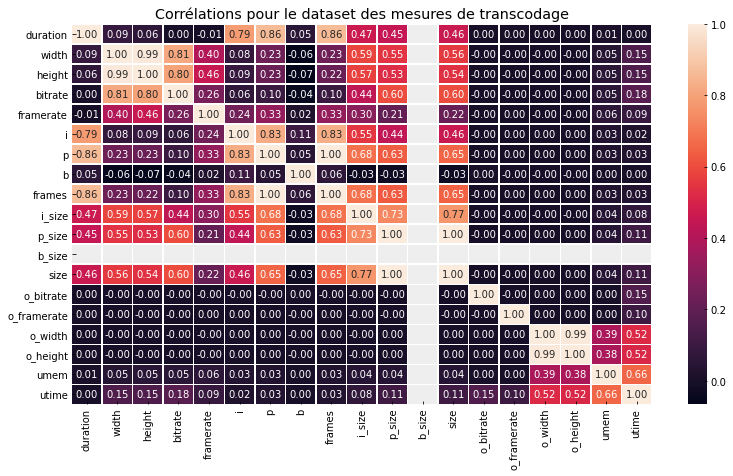

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(13, 7))
sns.heatmap(df_transcoding_mesurment.corr(), annot=True, linewidths=.5, fmt= '.2f').set(title="Corrélations pour le dataset des mesures de transcodage")

[Text(0.5, 1.0, 'Corrélations pour le dataset YouTube')]

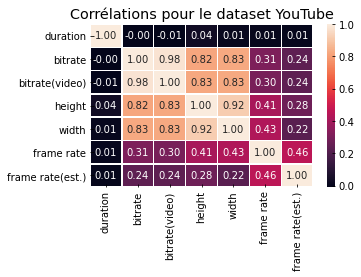

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
sns.heatmap(df_youtube_videos.corr(), annot=True, linewidths=.5, fmt= '.2f').set(title="Corrélations pour le dataset YouTube")

Dans les deux datasets, plus la résolution - `height` et `width` - de l'image est importante, plus le bitrate de la vidéo - `bitrate` et `bitrate(video)` - est élevé.

La durée `duration` est corrélée avec les nombres d'images composant la vidéo - `frames`, `i`, `p` et à l'exception de `b` - et dans une moindre mesure avec les tailles totales que ces images occupent et avec la taille `size` de la vidéo.

#### 3.1.2. Répartition des données non numériques

##### 3.1.2.1. Paramètres `codec` et `o_codec`

[Text(0.5, 1.0, 'Codec de sortie de transcodage')]

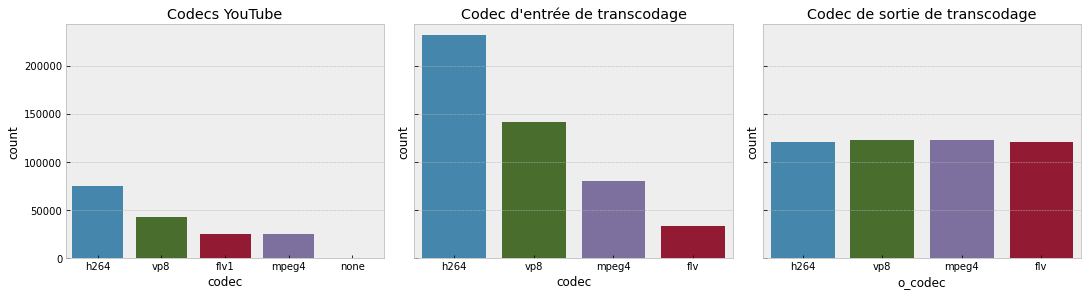

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, constrained_layout=True)
sns.countplot(x="codec", data=df_youtube_videos, ax=axes[0], palette=palette_codec, order = df_youtube_videos['codec'].value_counts().index).set(title="Codecs YouTube")
sns.countplot(x="codec", data=df_transcoding_mesurment, ax=axes[1], palette=palette_codec, order = df_transcoding_mesurment['codec'].value_counts().index).set(title="Codec d'entrée de transcodage")
sns.countplot(x="o_codec", data=df_transcoding_mesurment, ax=axes[2], palette=palette_codec, order = df_transcoding_mesurment['codec'].value_counts().index).set(title="Codec de sortie de transcodage")

##### 3.1.2.2. Paramètre `category`

Text(0.5, 0.98, 'Catégories des vidéos YouTube')

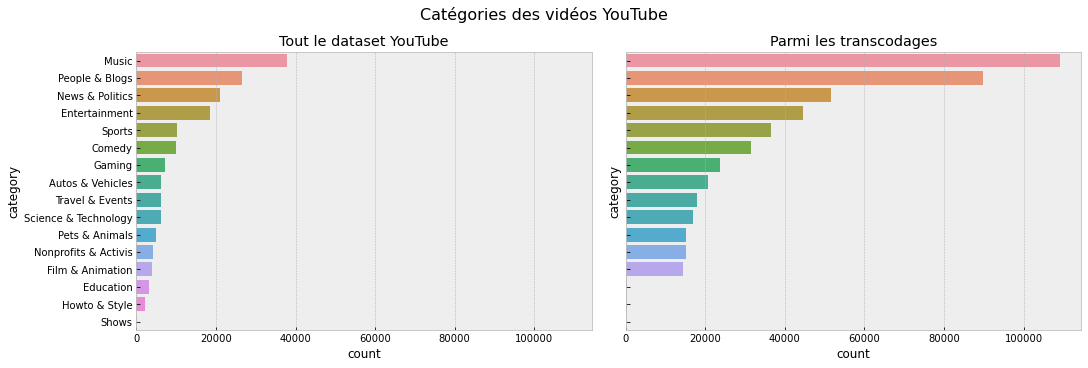

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True , constrained_layout=True)
sns.countplot(y="category", data=df_youtube_videos, order = df_youtube_videos['category'].value_counts().index, ax=axes[0])
axes[0].set_title("Tout le dataset YouTube")
sns.countplot(y="category", data=df_transcoding_mesurment, order = df_transcoding_mesurment['category'].value_counts().index, ax=axes[1])
axes[1].set_title("Parmi les transcodages")
fig.suptitle("Catégories des vidéos YouTube", fontsize=16)

On le rappelle, le dataset des transcodages est réalisé en récupérant aléatoirement des vidéos du dataset YouTube et en réalisant plusieurs transcodages entre différents codecs et pour différentes résolutions. Il n'est donc pas incohérent d'observer plus de transcodages que de vidéos YouTube.

### 3.2. Durée de transcodage

Nous souhaitons comprendre quels paramètres du fichier de vidéo influent sur la durée de son transcodage `utime`.

#### 3.2.1. Répartition du paramètre `utime`

Regardons d'abord la distribution de la durée des transcodages en fonction du codec d'entrée et du codec de sortie.

Chaque ligne correspond à un codec d'entrée `codec`. Chaque colonne correspond à un codec de sortie `o_codec`.

On constate que notre jeu de données n'est pas du tout normalisé et que la répartition du paramètre `utime` suit plutôt une loi exponentielle ou une loi de Poisson.

Text(0.5, 0.98, 'Durée de transcodage par codecs')

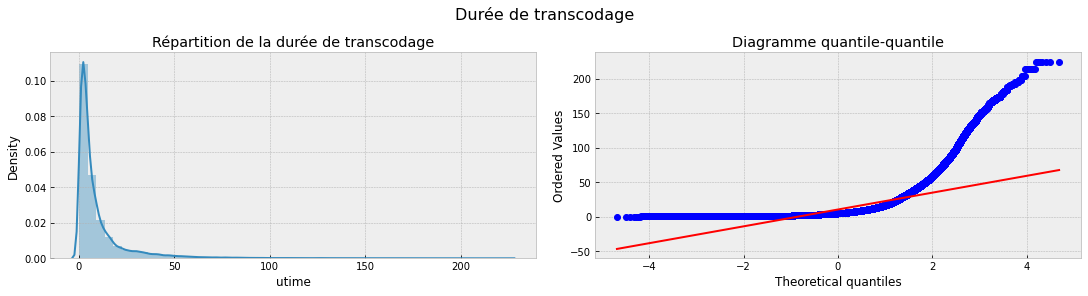

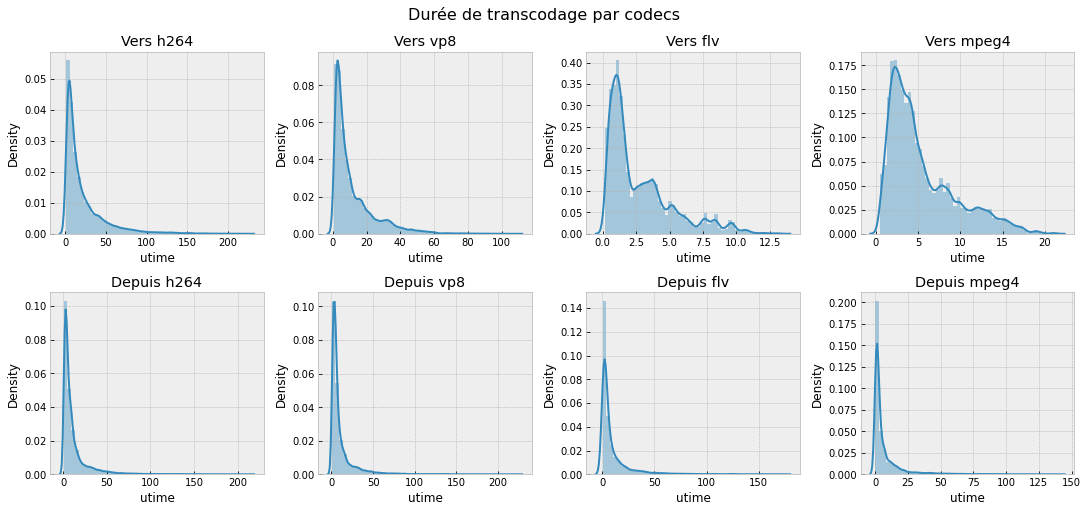

In [16]:
# g = sns.FacetGrid(df_transcoding_mesurment, col="o_codec", row="codec", height=4, margin_titles=True)
# g.map(sns.histplot, "utime")

# Histogramme de répartition et qq-plot
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=False, constrained_layout=True)
sns.distplot(df_transcoding_mesurment["utime"], ax=axes[0])
axes[0].set_title("Répartition de la durée de transcodage")
stats.probplot(df_transcoding_mesurment["utime"], plot=axes[1])
axes[1].set_title('Diagramme quantile-quantile')
fig.suptitle("Durée de transcodage", fontsize=16)

# Histogrammes de répartition paramétrés (en fonction du codec)
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharey=False, constrained_layout=True)
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["o_codec"]=="h264"), ax=axes[0, 0])
axes[0, 0].set_title("Vers h264")
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["o_codec"]=="vp8"), ax=axes[0, 1])
axes[0, 1].set_title("Vers vp8")
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["o_codec"]=="flv"), ax=axes[0, 2])
axes[0, 2].set_title("Vers flv")
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["o_codec"]=="mpeg4"), ax=axes[0, 3])
axes[0, 3].set_title("Vers mpeg4")
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["codec"]=="h264"), ax=axes[1, 0])
axes[1, 0].set_title("Depuis h264")
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["codec"]=="vp8"), ax=axes[1, 1])
axes[1, 1].set_title("Depuis vp8")
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["codec"]=="flv"), ax=axes[1, 2])
axes[1, 2].set_title("Depuis flv")
sns.distplot(df_transcoding_mesurment["utime"].where(df_transcoding_mesurment["codec"]=="mpeg4"), ax=axes[1, 3])
axes[1, 3].set_title("Depuis mpeg4")
fig.suptitle("Durée de transcodage par codecs", fontsize=16)

On constate bien que la répartition des valeurs `utime` est asymétrique, son coefficient d'asymétrie (*skewness*) est positif. De même, cette répartition est très concentrée et le sommet des répartitions est "très pointu", son coefficent d'applatissement (*kurtosis*) est très supérieur à 3.

In [17]:
# Skewness et Kurtosis
print("Skewness: %f" % df_transcoding_mesurment['utime'].skew())
print("Kurtosis: %f" % df_transcoding_mesurment['utime'].kurt())

Skewness: 4.207234
Kurtosis: 25.077473


#### 3.2.2. Relations avec les autres paramètres

On a déjà eu l'occasion de l'observer dans la partie précédente : `utime` n'est pas directement corrélé avec un grand nombre d'autres paramètres. On retrouve seulement `umem`, un paramètre de sortie inutilisable et `o_width` et `o_weight`, les paramètres de résolution de l'image de sortie qui, eux, sont donnés en entrée du transcodage.

In [18]:
# Paramètres les plus corrélés avec utime
df_transcoding_mesurment.corr()["utime"].sort_values(ascending = False)[1:]

umem           0.658152
o_width        0.518897
o_height       0.515267
bitrate        0.177376
o_bitrate      0.154949
width          0.152003
height         0.151514
p_size         0.109510
size           0.108972
o_framerate    0.104926
framerate      0.090951
i_size         0.075390
p              0.033875
frames         0.033760
i              0.019384
duration       0.003637
b              0.001768
b_size              NaN
Name: utime, dtype: float64

Text(0.5, 1.0, 'Rappel des corrélations')

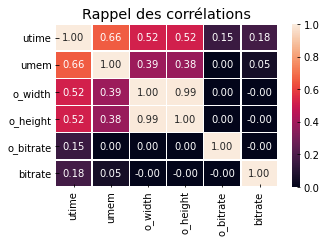

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
sns.heatmap(df_transcoding_mesurment[["utime", "umem", "o_width", "o_height", "o_bitrate", "bitrate"]].corr(), annot=True, linewidths=.5, fmt= '.2f')
axes.set_title("Rappel des corrélations")

#### 3.2.3. Relation avec la résolution de l'image de sortie

On observe plus précisément la durée de transcodage en fonction des dimension de l'image de sortie. Les durées `utime` sont très étalées, mais on voit bien que plus l'image de sortie a une bonne résolution, plus la durée de transcodage est importante.

D'ailleurs, passer les valeurs de résolution au logarithme pour "applatir" la durée de transcodage est inutile. Elle a tendance diminuer la corrélation entre ces derniers et `utime`, car seules quelques valeurs viennent étaler les durées de transcodage. On pourrait par contre attendre d'une normalisation de meilleurs résultats dans la régression de la durée de transcodage en fonction de la dimension souhaitée de la vidéo. On attendra de réaliser le modèle pour en décider.

En plus de confirmer les observations faites sur les deux premiers graphiques, le troisième graphique nous confirme que les hauteurs et les largeurs des vidéos sont toujours associées aux mêmes dimensions :
* 144 px de hauteur avec 176 px de largeur = 25 344 points
* 240 px de hauteur avec 320 px de largeur = 76 800 points
* 360 px de hauteur avec 450 px de largeur = 172 800 points
* 480 px de hauteur avec 640 px de largeur = 307 200 points
* 720 px de hauteur avec 1280 px de largeur = 921 600 points
* 1080 px de hauteur avec 1920 px de largeur = 2 073 600 points

Text(0.5, 0.98, "Durée de transcodage en fonction des dimension de l'image de sortie")

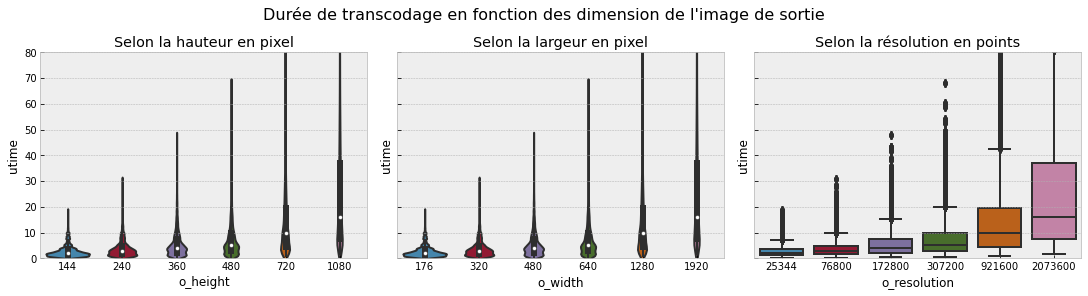

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True, constrained_layout=True)
sns.violinplot(data=df_transcoding_mesurment, x="o_height", y="utime", ax=axes[0])
axes[0].set_ylim(0, 80)
axes[0].set_title("Selon la hauteur en pixel")
sns.violinplot(data=df_transcoding_mesurment, x="o_width", y="utime", ax=axes[1])
axes[1].set_title("Selon la largeur en pixel")

# On créée un nouveau paramètre sur la résolution totale de l'image
df_transcoding_mesurment["o_resolution"] = df_transcoding_mesurment["o_height"] * df_transcoding_mesurment["o_width"]
sns.boxplot(data=df_transcoding_mesurment, x="o_resolution", y="utime", ax=axes[2])
axes[2].set_title("Selon la résolution en points")
fig.suptitle("Durée de transcodage en fonction des dimension de l'image de sortie", fontsize=16)

#### 3.2.4. Relation avec la mémoire utilisée

Même si on sait que `umem` et `utime` sont deux potentielles cibles pour cette étude et que les confronter n'a que peu d'intérêt dans le cadre de la prédiction de leurs valeurs respectives, on peut toutefois comparer leurs évolutions afin de mieux les comprendre.

Ainsi, même s'il semble que plus la mémoire allouée `umem` est importante, plus la durée de transcodage `utime` est importante, il apparaît surtout qu'on peut regrouper les transcodages sur le codec de sortie `o_codec` en comparant les deux paramètres précédents. Le codec de sortie h264 est le seul à occuper des mémoires totales de plus de 275 000 ko et cela vaut pour tous les codecs `codec` d'origine. On peut même remarquer qu'il y a deux groupes distincts de transcodages au-delà des 275 000 ko de mémoire allouée, et que dans chacun de ces groupes, la durée de transcodage augmente localement avec la mémoire allouée. D'ailleurs, plus le bitrate de la vidéo de sortie `o_bitrate` est élevé, plus la durée de transcodage dans ces deux groupes est élevée.

Text(0.5, 1.0, 'Durée de transcodage en fonction de la mémoire allouée')

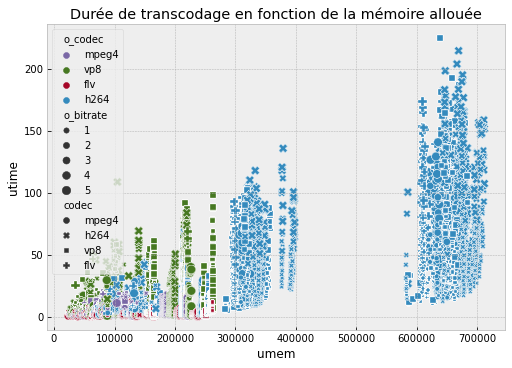

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5), sharey=False, constrained_layout=True)
sns.scatterplot(data=df_transcoding_mesurment, x="umem", y="utime", ax=axes, hue="o_codec", style="codec", size="o_bitrate", palette=palette_codec)
axes.set_title("Durée de transcodage en fonction de la mémoire allouée")

##### 3.2.4.1. Relation avec la mémoire utilisée pour les transcodages dans le codec h264

On va étudier plus en détails le rapport entre durée de transcodage et mémoire allouée pour les vidéos transcodées dans le codec h264 uniquement.

On se rend compte de plusieurs choses pour les transcodages vers le h264 :
* Le principal vecteur d'augmentation de mémoire allouée au transcodage est la résolution. Les transcodages sont ainsi regroupés en clusters selon leur résolution de sortie (on a ici choisi `o_height`) :
  * Les quatre premières paires de résolutions (de 144 px à 480 px de hauteur), regroupées en bas à gauche du graphique, impliquent une durée de transcodage faible (`utime` < 75 s) et une mémoire allouée `umem` toujours inférieure à 275 000 ko. On verra dans la partie suivante que les observations relevant de `utime` ou de `umem` au sein de ce cluster sont identiques à celles relevées pour l'étude de la relation avec la mémoire utilisée pour les transcodages dans les autres codecs ;
  * La paire de résolution 720 x 1280 px est intégralement regroupée entre les 275 000 ko et 400 000 ko de `umem` ;
  * La paire de résolution 1080 x 1920 px est intégralement regroupée entre les 575 000 ko et 725 000 ko de `umem`.
* Dans chaque cluster de résolution, les transcodages sur des vidéos à faibles bitrates d'entrée `bitrate` sont toujours à gauche, et occuppent donc moins de mémoire, tandis que les transcodages sur des vidéos à importants bitrates d'entrée sont toujours à droite, et occupent donc plus de mémoire.
* Rappel du précédent graphique, dans chaque cluster de résolution, les transcodages vers des vidéos à faibles bitrates de sortie `o_bitrate` sont toujours en bas, et prennent donc moins de temps, tandis que les transcodages vers des vidéos à importants bitrates de sortie sont toujours en haut, et prennent donc plus de temps.

Text(0.5, 1.0, 'Durée de transcodage en fonction de la mémoire utilisée vers le codec h264')

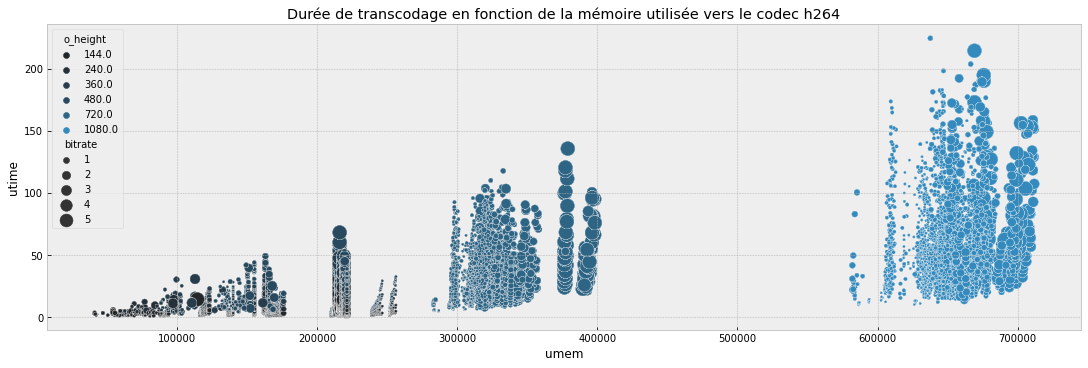

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5), sharey=False, constrained_layout=True)
sns.scatterplot(data=df_transcoding_mesurment.where(df_transcoding_mesurment["o_codec"]=="h264"), x="umem", y="utime", ax=axes, size="bitrate", sizes=(5, 200), hue="o_height", palette=sns.dark_palette(palette_codec["h264"], reverse=False, as_cmap=True))
axes.set_title("Durée de transcodage en fonction de la mémoire utilisée vers le codec h264")

Ainsi, pour les transcodages vers des codecs h264 :
* `utime` augmente avec `o_bitrate` (3.2.4.) ;
* `umem` est relativement équivalent pour les vidéos de même résolution (3.2.4.1.) ;
* `umem` augmente légèrement avec `bitrate` (3.2.4.1.)

##### 3.2.4.2. Relation avec la mémoire utilisée pour les transcodages dans les autres codecs

On réitère l'étude approfondie de la relation entre `utime` et `umem` pour les transcodages aux codecs de sortie différents de h264.

Ici, qu'importe le codec de sortie, les tanscodages ne se regroupent pas en clusters mais en colonnes, comme pour le premier cluster identifié sur le graphique précédent sur le transcodage vers le codec h264.

Text(0.5, 0.98, 'Durée de transcodage en fonction de la mémoire utilisée')

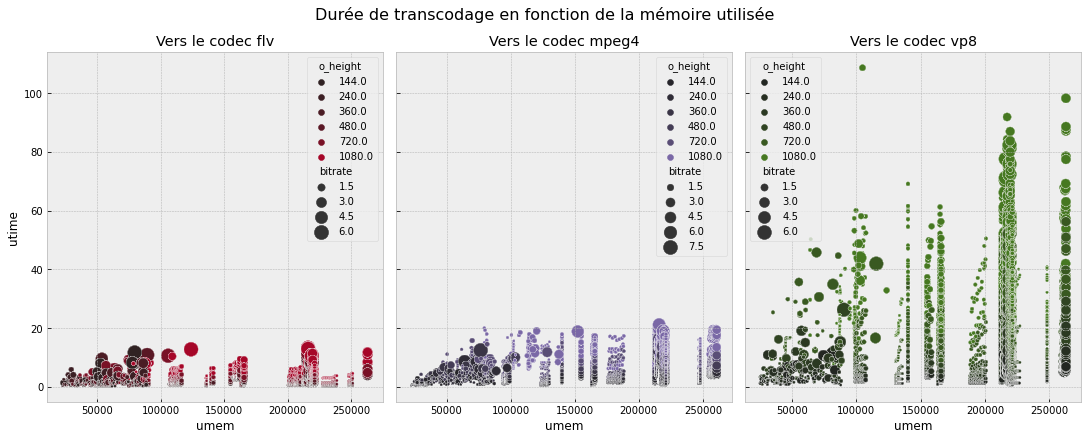

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True, constrained_layout=True)
sns.scatterplot(data=df_transcoding_mesurment.where(df_transcoding_mesurment["o_codec"]=="flv"), x="umem", y="utime", ax=axes[0], size="bitrate", sizes=(5, 200), hue="o_height", palette=sns.dark_palette(palette_codec["flv"], reverse=False, as_cmap=True))
axes[0].set_title("Vers le codec flv")
sns.scatterplot(data=df_transcoding_mesurment.where(df_transcoding_mesurment["o_codec"]=="mpeg4"), x="umem", y="utime", ax=axes[1], size="bitrate", sizes=(5, 200), hue="o_height", palette=sns.dark_palette(palette_codec["mpeg4"], reverse=False, as_cmap=True))
axes[1].set_title("Vers le codec mpeg4")
sns.scatterplot(data=df_transcoding_mesurment.where(df_transcoding_mesurment["o_codec"]=="vp8"), x="umem", y="utime", ax=axes[2], size="bitrate", sizes=(5, 200), hue="o_height", palette=sns.dark_palette(palette_codec["vp8"], reverse=False, as_cmap=True))
axes[2].set_title("Vers le codec vp8")
fig.suptitle("Durée de transcodage en fonction de la mémoire utilisée", fontsize=16)

Toutefois, on peut observer que sur une même colonne, à mémoire utilisée identique, ce qui est uniquement vecteur d'allongement de la durée de transcodage est le facteur `o_height`, donc la dimension de la vidéo en sortie de transcodage. On remarque également qu'une même colonne ne regroupe que des transcodages à bitrate identique.

Ce qui caractérise donc `umem` est donc encore une fois le bitrate (comme pour les transcodages vers le h264, où on retrouve finalement des colonnes similaires dans les clusters de résolutions). La seule différence avec les observations faites sur les transcodages vers le h264 est, qu'en plus de l'absence de clusters de résolution, `utime` augmente avec la résolution et non plus avec `o_bitrate`.

#### 3.2.5. Relation avec le bitrate

On étudie maintenant plus en détails le rapport entre `bitrate`, `o_bitrate` et `utime`.

Text(0.5, 1.0, 'Durée de transcodage en fonction de la mémoire utilisée vers le codec h264')

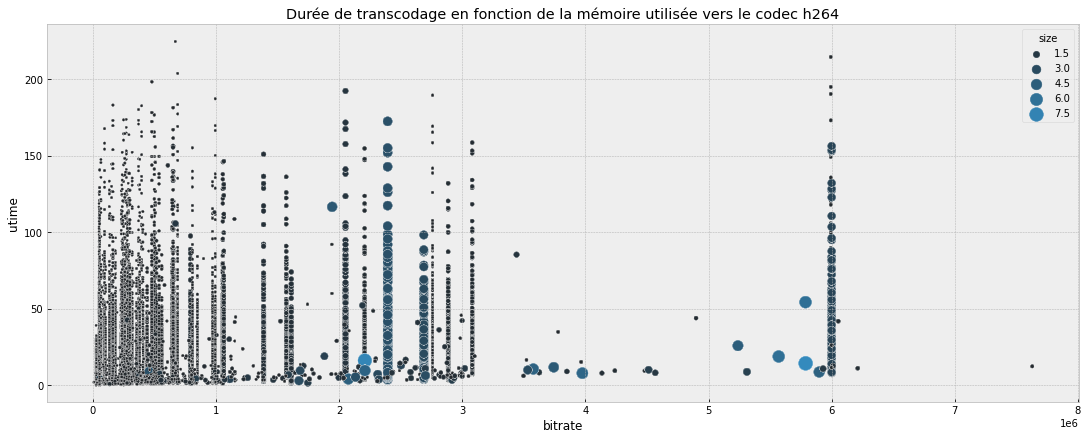

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharey=False, constrained_layout=True)
sns.scatterplot(data=df_transcoding_mesurment, x="bitrate", y="utime", ax=axes, size="size", sizes=(5, 200), hue="size", palette=sns.dark_palette(palette_codec["h264"], reverse=False, as_cmap=True))
axes.set_title("Durée de transcodage en fonction de la mémoire utilisée vers le codec h264")

(0.0, 80.0)

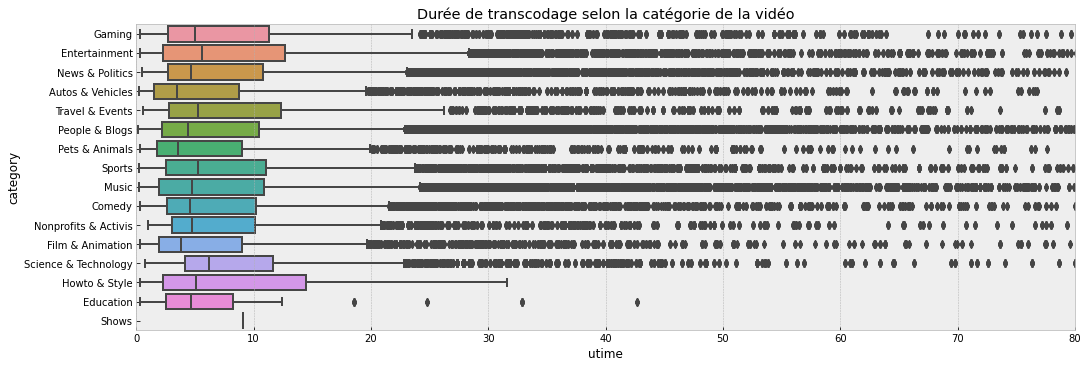

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5), sharey=True, constrained_layout=True)
sns.boxplot(data=df_transcoding_mesurment, x="utime", y="category")
axes.set_title("Durée de transcodage selon la catégorie de la vidéo")
axes.set_xlim(0, 80)

----

## 4. Modélisation

1. Traitement des données
2. Régression linéaire
3. Régression DNN

### 4.1. Traitement des données

#### 4.1.1. Génération du jeu de données

Pour le dataset que l'on utilisera pour notre modèle, on récupère toutes les valeurs numériques auxquelles on ajoute autant de colonnes à valeurs booléennes qu'il y a de valeurs textuelles différentes.

In [26]:
df_train = df_transcoding_mesurment.copy()

# Ajout des codecs d'entrée
codecs = df_train['codec'].unique()
for codec in codecs:
    df_train[codec] = [1 if (cod == codec) else 0 for cod in df_train['codec']]
    
# Ajout des codecs de sortie
o_codecs = df_train['o_codec'].unique()
for o_codec in o_codecs:
    df_train[str('o_' + o_codec)] = [1 if (o_cod == o_codec) else 0 for o_cod in df_train['o_codec']]

# Ajout des catégories
categories = df_train['category'].unique()
for category in categories:
    df_train[category] = [1 if (cat == category) else 0 for cat in df_train['category']]
    
df_train = df_train.drop(['id', 'o_resolution', 'codec', 'o_codec', 'category', 'b_size'], axis=1)

In [27]:
df_train.head()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,...,Pets & Animals,Sports,Music,Comedy,Nonprofits & Activis,Film & Animation,Science & Technology,Howto & Style,Education,Shows
0,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
1,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
2,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
3,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
4,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0


#### 4.1.2. Division des données en `train_dataset` et `test_dataset`

Afin d'entraîner puis de tester le modèle, on sépare le dataset en deux datasets `train_dataset` et `test_dataset`.

In [28]:
train_dataset = df_train.sample(frac=0.8, random_state=0)
test_dataset = df_train.drop(train_dataset.index)

In [29]:
train_dataset.head()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,...,Pets & Animals,Sports,Music,Comedy,Nonprofits & Activis,Film & Animation,Science & Technology,Howto & Style,Education,Shows
300140,426.945000,1280,720,1064703,29.0,228,12567,0,12795,11297544,...,0,0,0,1,0,0,0,0,0,0
370739,167.391660,1280,720,2207484,24.0,86,3931,0,4017,4369420,...,0,0,1,0,0,0,0,0,0,0
193531,384.451000,640,480,646432,29.0,205,11318,0,11523,2839955,...,0,0,0,0,1,0,0,0,0,0
6665,130.356670,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
194814,98.683334,176,144,55552,12.0,20,1164,0,1184,48267,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_dataset.head()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,...,Pets & Animals,Sports,Music,Comedy,Nonprofits & Activis,Film & Animation,Science & Technology,Howto & Style,Education,Shows
1,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
4,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
21,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
22,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0
27,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,...,0,0,0,0,0,0,0,0,0,0


#### 4.1.3. Suppression des cibles

On supprime de nos datasets les paramètres `utime` et `umem`, qui sont les valeurs cibles du modèle.

In [31]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels_utime = train_features.pop('utime')
test_labels_utime = test_features.pop('utime')

train_labels_umem = train_features.pop('umem')
test_labels_umem = test_features.pop('umem')

#### 4.1.4. Normalisation des données

Les données ne sont pas normalisées. Afin de rendre la formation du modèle plus stable, on normalise le dataset.

In [32]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
duration,2.840871e+02,2.910572e+02
width,7.171862e+02,5.147167e+02
height,4.600785e+02,2.644619e+02
bitrate,8.742974e+05,1.283875e+06
framerate,2.352392e+01,7.015877e+00
i,9.878983e+01,8.459577e+01
p,6.612423e+03,6.398013e+03
b,6.517453e+00,7.882653e+01
frames,6.717730e+03,6.472621e+03
i_size,3.297968e+06,4.746923e+06


On créée un calque `normalizer` qui applique par la suite la normalisation à une ligne donnée.

In [33]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[2.8408710e+02 7.1718622e+02 4.6007852e+02 8.7429744e+05 2.3523916e+01
 9.8789825e+01 6.6124233e+03 6.5174537e+00 6.7177305e+03 3.2979680e+06
 2.7893010e+07 3.1193482e+07 1.3933615e+06 2.1194410e+01 8.0217792e+02
 5.0374185e+02 1.6537510e-01 4.7531497e-01 2.9076508e-01 6.8544842e-02
 2.5224882e-01 2.5131059e-01 2.4846512e-01 2.4797550e-01 4.8626617e-02
 9.1505915e-02 1.0628693e-01 4.2156398e-02 3.6924340e-02 1.8369885e-01
 3.1118061e-02 7.4545942e-02 2.2339174e-01 6.4435586e-02 3.1446185e-02
 3.0008076e-02 3.4794088e-02 4.5373561e-04 5.8190955e-04 2.5634781e-05]


On compare la première ligne de `train_features` avec le dataframe `train_features` auquel on a appliqué le calque.

In [34]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[     426.94     1280.        720.    1064703.         29.        228.
     12567.          0.      12795.   11297544.   45523691.   56821235.
    820000.         12.        480.        360.          0.          1.
         0.          0.          1.          0.          0.          0.
         0.          0.          0.          0.          0.          0.
         0.          0.          0.          1.          0.          0.
         0.          0.          0.          0.  ]]

Normalized: [[ 0.49  1.09  0.98  0.15  0.78  1.53  0.93 -0.08  0.94  1.69  0.3   0.42
  -0.33 -1.38 -0.53 -0.46 -0.45  1.05 -0.64 -0.27  1.72 -0.58 -0.57 -0.57
  -0.23 -0.32 -0.34 -0.21 -0.2  -0.47 -0.18 -0.28 -0.54  3.81 -0.18 -0.18
  -0.19 -0.02 -0.02 -0.01]]


#### 4.1.5. Visualisation des données normalisées

[Text(0.5, 1.0, 'Corrélations pour le dataset train_features')]

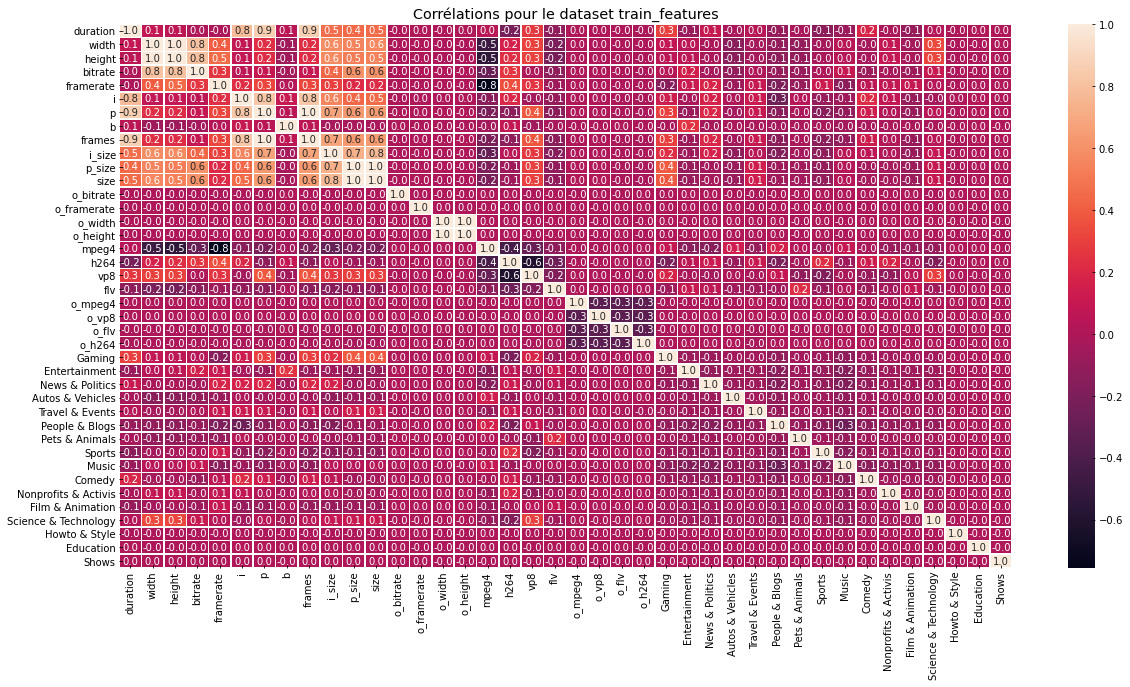

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(train_features.corr(), annot=True, linewidths=.5, fmt= '.1f').set(title="Corrélations pour le dataset train_features")

### 4.2. Régression linéaire

#### 4.2.1. Entrée unique avec `o_width`

Pour commencer, on réalise une régression linéaire à entrée unique avec l'aide du paramètre le plus corrélé avec `utime` : `o_width`. Toutefois, au vu de la corrélation relativement faible entre ces deux paramètres, on sait d'ores et déjà que ce modèle ne sera pas viable.

In [37]:
o_width = np.array(train_features['o_width'])

o_width_normalizer = preprocessing.Normalization(input_shape=[1,])
o_width_normalizer.adapt(o_width)

In [38]:
o_width_model = tf.keras.Sequential([
    o_width_normalizer,
    layers.Dense(units=1)
])

o_width_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Le modèle doit prédire `utime` avec `o_width`.

On lance le modèle sans entraînement avec les 10 premières valeurs de largeur de sortie de transcodage. Les valeurs de sortie ne seront évidemment pas bonnes.

In [39]:
o_width_model.predict(o_width[:10])

array([[-0.88668174],
       [ 1.3150377 ],
       [-0.44633785],
       [-0.88668174],
       [ 1.3150377 ],
       [-1.7233351 ],
       [-0.88668174],
       [-0.44633785],
       [-0.88668174],
       [-0.88668174]], dtype=float32)

On compile le modèle et on choisit les critères d'efficacité du modèle.

In [40]:
o_width_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

On entraîne le modèle à 10 reprises avec le dataset `train_labels`.

In [43]:
%%time
history = o_width_model.fit(
    train_features['o_width'], train_labels_utime,
    epochs=10,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 41 s


On visualise les résultats sur les derniers entraînements. Ils ne sont pas très concluants.

In [44]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
5,6.857791,6.808781,5
6,6.857138,6.797331,6
7,6.856510,6.793504,7
8,6.856993,6.792984,8
9,6.857226,6.798978,9


On les affiche epoch après epoch.

In [100]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [utime]')
  plt.legend()
  plt.grid(True)

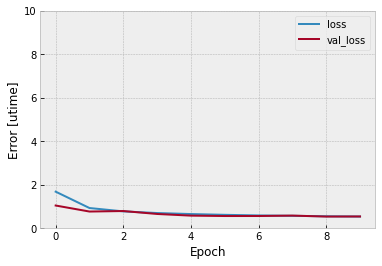

In [101]:
plot_loss(history)

On les enregistre à des fins de comparaisons avec les différents autres modèles que l'on va mettre en place.

In [48]:
test_results = {}

test_results['o_width_model'] = o_width_model.evaluate(
    test_features['o_width'],
    test_labels_utime, verbose=0)

In [58]:
x = tf.linspace(0.0, 2000, 2001)
y = o_width_model.predict(x)

In [60]:
def plot_o_width_model(x, y):
  plt.scatter(train_features['o_width'], train_labels_utime, label='Réalité')
  plt.plot(x, y, color='k', label='Prédiction')
  plt.xlabel('o_width')
  plt.ylabel('utime')
  plt.legend()

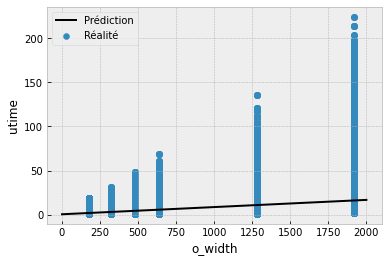

In [61]:
plot_o_width_model(x, y)

#### 4.2.2. Entrées multiples

In [62]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [63]:
linear_model.predict(train_features[:10])

array([[-0.09238124],
       [ 0.03533474],
       [-0.2681925 ],
       [ 0.9724566 ],
       [-0.4535384 ],
       [-1.2644455 ],
       [ 0.5419799 ],
       [-1.9581909 ],
       [ 0.38545862],
       [ 0.3013906 ]], dtype=float32)

In [64]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(40, 1) dtype=float32, numpy=
array([[ 0.08779827],
       [-0.06849742],
       [-0.18588676],
       [ 0.2054623 ],
       [ 0.19238189],
       [-0.01471081],
       [ 0.35631672],
       [-0.07414645],
       [-0.09000537],
       [ 0.10419565],
       [ 0.2252827 ],
       [ 0.29292145],
       [-0.2210415 ],
       [ 0.2568687 ],
       [ 0.28342828],
       [-0.26844987],
       [ 0.25330713],
       [-0.12648469],
       [ 0.04055223],
       [ 0.05338621],
       [-0.3297723 ],
       [ 0.28259912],
       [ 0.09446552],
       [ 0.23052636],
       [ 0.19169256],
       [-0.30913007],
       [ 0.13499287],
       [ 0.3074681 ],
       [ 0.35358456],
       [-0.10036528],
       [ 0.07934272],
       [ 0.3797085 ],
       [ 0.25695565],
       [ 0.3231344 ],
       [ 0.06970644],
       [-0.06096241],
       [ 0.17380014],
       [ 0.10233632],
       [-0.04279682],
       [-0.15046048]], dtype=float32)>

In [65]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [66]:
%%time
history = linear_model.fit(
    train_features, train_labels_utime, 
    epochs=10,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 41.3 s


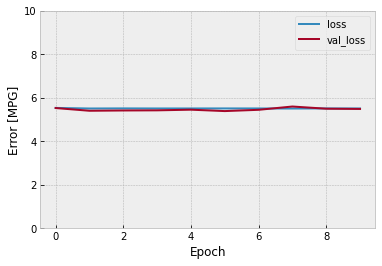

In [67]:
plot_loss(history)

In [69]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels_utime, verbose=0)

### 4.3. Régression DNN

On va maintenant réaliser un réseau de neurones pour notre régression DNN (*deep neural network*).

In [70]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#### 4.3.1. Entrée unique avec `o_width`

In [71]:
dnn_o_width_model = build_and_compile_model(o_width_normalizer)

In [72]:
dnn_o_width_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [89]:
%%time
history = dnn_o_width_model.fit(
    train_features['o_width'], train_labels_utime,
    validation_split=0.2,
    verbose=0, epochs=10)

Wall time: 54.9 s


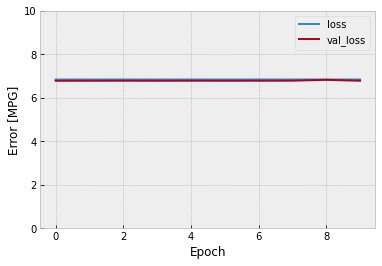

In [90]:
plot_loss(history)

In [91]:
x = tf.linspace(0.0, 2000, 2001)
y = dnn_o_width_model.predict(x)

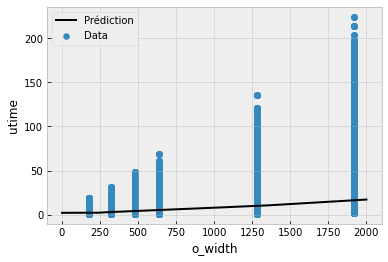

In [92]:
plot_horsepower(x, y)

In [93]:
test_results['dnn_o_width_model'] = dnn_o_width_model.evaluate(
    test_features['o_width'], test_labels_utime,
    verbose=0)

#### 4.3.2. Entrées multiples

In [94]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 40)                81        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 6,930
Trainable params: 6,849
Non-trainable params: 81
_________________________________________________________________


In [95]:
%%time
history = dnn_model.fit(
    train_features, train_labels_utime,
    validation_split=0.2,
    verbose=0, epochs=10)

Wall time: 58.3 s


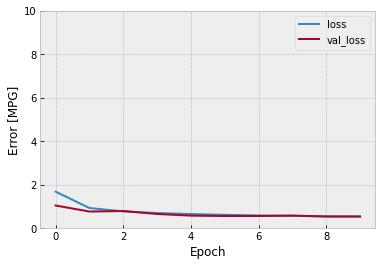

In [96]:
plot_loss(history)

In [97]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels_utime, verbose=0)

### 4.4. Analyse des performances des modèles

In [99]:
pd.DataFrame(test_results, index=['Mean absolute error [utime]']).T

,Mean absolute error [utime]
o_width_model,6.859736
linear_model,5.542025
dnn_o_width_model,6.846964
dnn_model,0.557726
